# Premise

The purpose of this analysis is to explore  the forecasting for multiple zip codes in the United States in order to assess the best possible opportunities for real estate investment.

In pursuit of this investigation, I will attempt to begin at a national level, using ARIMA and/or SARIMAX methodology and modeling to assess the most promising locations.

The models will be tuned in such a way as to capture this information with the greatest precision and accuracy as possible before drillingn down to the state, county, city, and ultimately zip code levels. 

I will not attempt to ascertain the top five zip codes in the entire country. Instead I will attempt to locate the top zipcodes in the top city of the top county of the top state. This method will ensure strength in the surrounding areas, rather than pursuing what could be isolated zip codes showing unsustainable strength. 

# Preparing Libraries, Functions, and Importing Data

## Importing libraries

In [1]:
import pandas as pd
from pandas import datetime
import numpy as np
import statsmodels
import statsmodels.api as sm
import itertools
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns
import warnings
import random
import plotly.plotly as py
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set()
sns.set_style({'axes.facecolor': (.75, .75, .75, .7)})

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

## My Functions

### SARIMAX Forecast

The SARIMAX and ARIMA testing and forecasting functions will be the primary tools I will use for modeling and graphing in both exploration and conclusion.

In [3]:
def forecast_SARIMAX(data, order = (1,1,1), 
              seasonal_order = (0,0,0,0),
              start = '2018-04-01', 
              end = '2023-04-01',
              plot_start = '1996-04-01'):
    """Takes in zip code home value arguments to create SARIMAX summary table, 
    diagnostic graphs, and forecasting graph.
    
    Prameters:        
    
        zip: Series
            Time Series with median home values.
        
        order: tuple (optional)
            pdq for SARIMAX model.
            If empty, defaults to (1,1,1)
        
        seasonal_order: tuple (optional)
            PDQS for SARIMAX model.
            If empty, defaults to (0,0,0,0)
        
        start: string
            Beginning date for time series predictions.
            If empty, defaults to '2018-04-01'
        
        end: string
            End date for time series predictions. Note that if this date
            is beyond the end of the time series, it will create a forecast
            with confidence intervals.
            If empty, defaults to '2023-04-01'
            
        plot_start: string
            Start date for where to begin the graph on on the x axis.
            If empty, defaults to '1996-04-01'
    
    Returns:
        
        statsmodels SARIMAX summary table, diagnostic graphs, and forecasting
        graph."""
    
    # Creating a model
    model = sm.tsa.statespace.SARIMAX(data, order = order,
                                      seasonal_order = seasonal_order,
                                      enforce_stationarity = True,
                                      enforace_invertability = True)
    
    output = model.fit()
    # Print out summary table and aic score
    print(output.summary().tables[1])
    print('AIC: ', output.aic)
    
    #The prediction can be used to forecast into the future.
    prediction = output.get_prediction(start = pd.to_datetime(start),
                                       end = pd.to_datetime(end),
                                       dynamic = False)
    
    # Capturing confidence intervals
    pred_conf = prediction.conf_int()
    
    # Create diagnistic graphs
    output.plot_diagnostics(figsize = (12, 8));
    plt.show()
    
    # Create the prediction graph
    rcParams['figure.figsize'] = 12,8
    ax = data[plot_start:].plot(label = 'observed')
    
    # Plotting based on the predicted mean and filling in confidence intervals
    prediction.predicted_mean.plot(ax = ax, label = 'Forecast', alpha = .9)
    ax.fill_between(pred_conf.index, pred_conf.iloc[:, 0], pred_conf.iloc[:, 1],
                    color =  'g', alpha = .5)
    
    #Changing y limits so that the graph is in proper scale with 0 min.
    ax.set_ylim(bottom = 0)
    
    ax.legend(loc = 'upper left')
    plt.show()

### SARIMAX Train-Test

In [4]:
def train_test_SARIMAX(data, order = (1,1,1), 
              seasonal_order = (0,0,0,0),
              start = '2013-04-01', 
              end = '2018-04-01',
              plot_start = '1996-04-01'):
    """Takes in zip code home value arguments to create SARIMAX summary table, 
    diagnostic graphs, and forecasting graph.
    
    Prameters:        
    
        data: Series
            Time Series with median home values.
        
        order: tuple (optional)
            pdq for SARIMAX model.
            If empty, defaults to (1,1,1)
        
        seasonal_order: tuple (optional)
            PDQS for SARIMAX model.
            If empty, defaults to (0,0,0,0)
        
        start: string
            Beginning date for time series predictions.
            If empty, defaults to '2018-04-01'
        
        end: string
            End date for time series predictions. Note that if this date
            is beyond the end of the time series, it will create a forecast
            with confidence intervals.
            If empty, defaults to '2023-04-01'
            
        plot_start: string
            Start date for where to begin the graph on on the x axis.
            If empty, defaults to '1996-04-01'
    
    Returns:
        
        statsmodels SARIMAX summary table, diagnostic graphs, and forecasting
        graph."""
    
    # Splitting up the data in train and test sets by date.    
    train = data[:start]
    test = data[start:]
    
    # Creating a model
    model = sm.tsa.statespace.SARIMAX(train, order = order,
                                      seasonal_order = seasonal_order,
                                      enforce_stationarity = False,
                                      enforace_invertability = False)
    
    output = model.fit()
    # Print out summary table and aic score
    print(output.summary().tables[1])
    print('AIC: ', output.aic)
    
    #The prediction can be used to forecast into the future.
    prediction = output.get_prediction(start = test.index[0],
                                       end = pd.to_datetime(end),
                                       dynamic = False)
    
    # Capturing confidence intervals
    pred_conf = prediction.conf_int()
    
    # Create diagnistic graphs
    output.plot_diagnostics(figsize = (12, 8));
    plt.show()
    
    # Create the prediction graph
    rcParams['figure.figsize'] = 12,8
    ax = data[plot_start:].plot(label = 'actual')
    
    # Plotting based on the predicted mean and filling in confidence intervals
    prediction.predicted_mean.plot(ax = ax, label = 'Forecast', alpha = .9)
    ax.fill_between(pred_conf.index, pred_conf.iloc[:, 0], pred_conf.iloc[:, 1],
                    color =  'g', alpha = .5)
    
    #Changing y limits so that the graph is in proper scale with 0 min.
    ax.set_ylim(bottom = 0)
    
    ax.legend(loc = 'upper left')
    plt.show()

### ARIMA Forecast

In [5]:
def forecast_ARIMA(data, order = (1,1,1),
              start = '2018-04-01', 
              forecast_length = 60,
              figsize = (12,5),
              diagnostics = False,
              denver = False,
              color=None):
    """Model and graph a zip code time series.
    
    Parameters:
    
        data: Series
            Time Series with median home values.
        
        order: tuple (optional)
            pdq for SARIMAX model.
            If empty, defaults to (1,1,1)
            
        start: str
            Date to start the forecast from in yyyy-mm-dd format.
            
        forecast_length: int
            Number of months to extend the forecast.
            
        figsize: tuple
            Creates the size of the graph.
            
        diagnostics: bool
            Determines whether to display table of model information.
            
        denver: bool
            Indicates whether to use Broncos colors for Denver
            
        color: str
            Color of lines on the resulting graph.
            
    Returns:
        A graph and, if selected, diagnostic information about p-values etc."""
            
    
    # Will need a placeholder series to build the forecast against.
    ext_dates = pd.Series(range(0,forecast_length,1), 
                          index = pd.date_range(start, 
                                                periods = forecast_length, 
                                                freq = 'MS'))
    
    # ARIMA doesn't like series names to be integers, so zipcodes must be 
    # changed to strings.
    data.name = str(data.name)
    
    model = statsmodels.tsa.arima_model.ARIMA(data, order=order)  
    fitted = model.fit()  
    print(fitted.summary()) if diagnostics == True else ''
    
    # Forecast
    fc, se, conf = fitted.forecast(forecast_length, alpha=0.05)

    # Make as pandas series
    fc_series = pd.Series(fc, index=ext_dates.index)
    lower_series = pd.Series(conf[:, 0], index=ext_dates.index)
    upper_series = pd.Series(conf[:, 1], index=ext_dates.index)
    
    # Plot
    plt.figure(figsize=figsize, dpi=100)
    
    # Create the special option for a Rockies/Broncos version.
    if denver == True:
        plt.plot(data, label='current data', color = 'blue')
        plt.plot(fc_series, label='forecast', color = 'orange')
        plt.fill_between(lower_series.index, lower_series, upper_series, 
                         color='white', alpha=.85)
        plt.grid(b=True, axis='y', color = 'purple')
    else:
        plt.plot(data, label='current data')
        plt.plot(fc_series, label = 'forecast')
        plt.fill_between(lower_series.index, lower_series, upper_series,
                         color=color, alpha=.5)
    
    plt.title(data.name)
    plt.ylim(bottom = 0)
    plt.ylabel('value in $')
    plt.xlabel('year')
        
    plt.legend(loc='upper left', fontsize=10)
    
    # Now plot all the common elements.
    plt.show()

### ARIMA Forecast Subplots

In [6]:
def forecast_ARIMA_sub(data, ax, order = (1,1,0),
              start = '2018-04-01', 
              forecast_length = 60,
              diagnostics = False,
              figsize = (12,5),
              denver = False,
              intervals = True,
              color=None,
              lw=1,
              ls='-'):
    """Model and graph a zip code time series in subplots.
    
    Parameters:
    
        data: Series
            Time Series with median home values.
        
        order: tuple (optional)
            pdq for SARIMAX model.
            If empty, defaults to (1,1,1)
            
        start: str
            Date to start the forecast from in yyyy-mm-dd format.
            
        forecast_length: int
            Number of months to extend the forecast.
            
        figsize: tuple
            Creates the size of the graph.
            
        diagnostics: bool
            Determines whether to display table of model information.
            
        denver: bool
            Indicates whether to use Broncos colors for Denver
            
        intervals: bool
            Whether or not to display the confidence intervals on graph.
                
        color: str
            Color of lines on the resulting graph.
            
        lw: int
            line width for graph.
            
        ls: str
            line style for graph. '-', '--' etc.
            
    Returns:
        A graph and, if selected, diagnostic information about p-values etc."""
    # Will need a placeholder series to build the forecast against.
    ext_dates = pd.Series(range(0,forecast_length,1), 
                          index = pd.date_range(start, 
                                                periods = forecast_length, 
                                                freq = 'MS'))
    
    # ARIMA doesn't like series names to be integers, so zipcodes must be 
    # changed to strings.
    data.name = str(data.name)
    
    model = statsmodels.tsa.arima_model.ARIMA(data, order=order)  
    fitted = model.fit()  
    print(fitted.summary()) if diagnostics == True else ''
    
    # Forecast
    fc, se, conf = fitted.forecast(forecast_length, alpha=0.05)

    # Make as pandas series
    fc_series = pd.Series(fc, index=ext_dates.index)
    lower_series = pd.Series(conf[:, 0], index=ext_dates.index)
    upper_series = pd.Series(conf[:, 1], index=ext_dates.index)
    
    # Plot   
    # Create the special option for a Rockies/Broncos version.    
    if denver == True:
        ax.plot(data, color = 'blue', lw=lw, ls=ls)
        ax.plot(fc_series, label=data.name, color = 'orange', lw=lw, ls=ls)
        ax.fill_between(lower_series.index, lower_series, upper_series, 
                         color='white', alpha=.7) if intervals else ''
#         ax.grid(b=True, axis='y', color = 'purple', lw = 1)
        ax.set_ylim(0, 1100000)
    else:
        ax.plot(data, lw=lw, color = 'g', ls=ls)
        ax.plot(fc_series, label=data.name, lw=lw, color=color, ls=ls)
        ax.fill_between(lower_series.index, lower_series, upper_series,
                            color = 'g', alpha=.4) if intervals else ''
        ax.set_ylim(0, 1100000)
    
    ax.set_title(data.name, fontsize = 28)
    ax.set_ylim(bottom = 0)
    ax.set_ylabel('value in $', fontsize = 20)
    ax.set_xlabel('year', fontsize = 20)
    ax.tick_params(axis="x", labelsize=16)
    ax.tick_params(axis="y", labelsize=16)
        
    ax.legend(loc='upper left', fontsize=16)
    
    return ax

### ARIMA Train-Test

In [7]:
def train_test_ARIMA(data, order = (1,1,0),
              start = '2018-04-01'):
    """Model and graph a zip code time series.
    
    Parameters:
    
        data: Series
            Time Series with median home values.
        
        order: tuple (optional)
            pdq for SARIMAX model.
            If empty, defaults to (1,1,1)
            
        start: str
            Date to start the test from in yyyy-mm-dd format.
            Test will proceed to end of data set.
                        
    Returns:
        A graph showing train vs test information, and diagnostic chart."""
    
    # Splitting up the data in train and test sets by date.
    train = data[:start]
    test = data[start:]
    
    # ARIMA doesn't like series names to be integers, so zipcodes must be 
    # changed to strings.
    data.name = str(data.name)
    
    model = statsmodels.tsa.arima_model.ARIMA(train, order=order)  
    fitted = model.fit()  
    print(fitted.summary())

    # Forecast
    fc, se, conf = fitted.forecast(len(test), alpha=0.05)

    # Make as pandas series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(conf[:, 0], index=test.index)
    upper_series = pd.Series(conf[:, 1], index=test.index)

    # Plot
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(train, label='training')
    plt.plot(test, label='actual')
    plt.plot(fc_series, label='predicted')
    plt.fill_between(lower_series.index, lower_series, upper_series, 
                     color='g', alpha=.5)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.ylim(0)
    plt.show()

### AIC Grid Search

This function attempts modeling with all combinations of hyperparameters as specified.

In [8]:
def aic_search(data, p_max=2, d_max=2, q_max=2, end='2013-04-01'):
    """Grid search to determine starting parameters for ARIMA modeling.
    
    Paramaters:
    
        data: series
            A time series of one zip with mean value data.
            
        p_max: int
            Max AR order value, or 'p'. This will be one greater  than 
            the largest value the grid search with check in its combination set. 
            
        d_max: int
            Max differencing order value, or 'd'. This will be one greater  than 
            the largest value the grid search with check in its combination set. 
            
        q_max: int
            Max differencing order value, or 'q'. This will be one greater  than 
            the largest value the grid search with check in its combination set. 
            
        end: str
            Date to end the training portion of the time series for determing
            parameters."""
        

    # I played with the length of the test period to ensure I had confidence
    # in the ultimate hyperparameter set that I used for forecasting.
    test_data = data[:end]
    
    #Turning the start/end dates into a forecast length.
    forecast_len = ((pd.to_datetime('2018-04-01') - pd.to_datetime(end)).days
                    // 365)*2
    
    # ARIMA doesn't like series names to be integers, so zipcodes must be 
    # changed to strings.
    data.name = str(test_data.name)
    
    # Set the ranges specified for parameters
    p = range(0,p_max)
    d = range(0,d_max)
    q = range(0,q_max)

    # Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))
    
    # Iterating through each of the combinations and running the model for each
    # to see which one has the lowest AIC score.
    ans = []
    ans_df = pd.DataFrame()
    rejects = []

    for comb in pdq:
        try:
            # create and fit the model
            model = statsmodels.tsa.arima_model.ARIMA(test_data, 
                                                      order=(comb)) 
            fitted = model.fit()

            # Add the newest combination to the ans list
            ans.append([comb, fitted.aic])

            # Create the variables for forecast, confidence intervals, and
            # whatever the hell se is.
            fc, se, conf = fitted.forecast(forecast_len, alpha=0.05)

            i = forecast_len - 1
            fc = round(fc[i],1)
            interval_size = round(conf[i,1] - conf[i,0],0)
            df_data = [[comb, fitted.aic, interval_size, fc]]
            columns = ['Orders', 'AIC', 'IntervalSize', 'forecasted_value']

            # Fill the array with AIC results and the dataframe with additional info
            temp_df = pd.DataFrame(data = df_data, columns = columns)
            ans_df = pd.concat([ans_df, temp_df])

        except:
            # If any combination fails, we probably want to know about it so 
            # we can potentially correct the problem and re-try. It might be 
            # the winner.
            rejects.append(comb)
#         print('Combination {} failed.'.format(comb))
            continue
    
    ans_df = ans_df.sort_values('AIC', ascending = True)
    ans.sort(key = lambda x: x[1], reverse = False)
    
    return ans, ans_df, rejects

### Nationwide Modeling

This is the main function for making the search to determine forecasting for every zip code in the data set. Can be used with smaller data sets as well.

In [72]:
def national_models(source, info, params=(3,1,2)):
    """Takes parameters and a column set to create models for.
    
    parameters:
        source: DataFrame
            Specifies which data to use during modeling.
            
        info: DataFrame
            DataFrame housing zip info such as city and county.
            
        params: tuple of ints
            Set of parameters to use for modeling.
            
    returns:
        DataFrame housing the zip information for city etc, along with 
        projections for each year from last date of data set forward to 10 
        years, including $ and % gain."""
    
    # This is the blank DataFrame that all records will be concatenated to as they
    # are created.
    df = pd.DataFrame()  
    
    # The following loop will cycle through every zip code, create projections out
    # ten years, and build the all_zip_models DataFrame piece by piece.
    # for column in zdf_by_zip.columns[1:2]:
    for column in source.columns:
        try:
            data = source[column]
            # Will need a placeholder series to build the forecast against.
            ext_dates = pd.Series(range(0,120,1), 
                                  index = pd.date_range('2018-04-01', 
                                                        periods = 120, 
                                                        freq = 'MS'))

            # ARIMA doesn't like series names to be integers, so zipcodes must be 
            # changed to strings.
            data.name = str(data.name)

            model = statsmodels.tsa.arima_model.ARIMA(data, 
                                                      order = params)
            output = model.fit()

            # Forecast
            fc, se, conf = output.forecast(120, alpha=0.05)

            # Make as pandas series
            forecast = pd.Series(fc, index=ext_dates.index)

            # projections will house the metadata for each zip, and columns will
            # house the projection data as it is created.
            projections = [column]
            columns = ['Zip']

            # I'll be iterating 1 year at a time, beginning 1 year from the last 
            # date in the data set.
            j = 11
            columns.extend(info.columns)
            columns.append('2018-04-01')

            # Continuing to add the zip metadata.
            for col_name in info.columns:
                projections.append(zip_info.loc[column][col_name])

            # Defining where we will begin the forecast.
            start = source.loc['2018-04-01'][column]
            projections.append(start)

            # The 10 years of projections are added one at a time. 
            # Percent Gain is also added in at this point.
            for i in range(0, 10):
                this_proj = round(forecast[j],2)
                this_gain = round((this_proj - start) / start,2)
                projections.extend([this_proj, this_gain])
                columns.extend([str(i + 1) + '_Year', str(i + 1) + '_Gain'])
                j += 12
            # Create a temporary dataframe from the data I've created to 
            # concatenate to the master DataFrame.
            temp = pd.DataFrame([projections], columns = columns)
            df = pd.concat([df, temp], axis = 0,
                                       ignore_index = True)

        except:
            continue
            
    return df

### Grouping by Area

This function will group records together as specified by either state, county, or city.

In [10]:
def group_areas(data, group = 'State', 
                years_ahead = 10):
    """Group a zipcode DataFrame in zip-wide format 
    according to state, county, or city
        
    Parameters:
        
        data (DataFrame)
            Zipcode DataFrame in zip-wide format with forecasts
            
        group (String)
            State, CountyName, or City value from zipcode dataframe.
            
        years_ahead (Int)
            1 to 10 years for forecast length.
            
    Returns:
        DataFrame with areas grouped by top precentage of gain.

    """
    forecast_len = str(years_ahead) + '_Gain'
    
    df = pd.DataFrame(data.groupby(
        group)[forecast_len].mean()).sort_values(
        forecast_len, ascending = False)

    df['Rank'] = [i + 1 for i in range(0, len(df))]
    
    return df

### Drill for Zip Codes

This is the function that will be used to find the top zip codes in the specified state, as discovered by drilling into county, city, and zipcode levels.

In [11]:
def drill_for_zips(state, 
                   data=None, 
                   num_results=5,
                   years_ahead=10):
    """Drills down from state through county and city levels to find the 
    top ranked zip codes by ranking of precent gain over specified years.
    
    Parameters:
    
        state (string)
            In capital abbreviated format ('CA'), specifies the state
            to investigate.
            
        data (DataFrame)
            Generally uses all_zip_ranked or another DataFrame 
            with zip codes ranked by percent gains, 1 - 5 years out.
            
        num_results (Int)
            How many results to display, ranked from the first down.
            
        years_ahead (Int)
            How many years ahead to look when searching for percent gain."""
            
    #Create df of all records in the prescribed state
    top_state_df = data[data['State'] == state]

    # create df of all counties within the specified state.
    county_df = group_areas(top_state_df, 'CountyName', years_ahead)
    
    # This will be the list of top zip codes that will be used to create the 
    # dataframe that will be returned.
#     top_zips = []
    
    top_zips = pd.DataFrame()
    
    # This will loop through the necessary data sets, drilling into each 
    # county and city until the specified number of results has been reached.
    i = 0
    while len(top_zips) < num_results:
                
        # Create a df of only the data for the top county in this state.
        # Iterates if not enough records in the first county.
        top_county_df = top_state_df[top_state_df['CountyName']
                               == county_df.index[i]]
        
        # Drilling to the city level.
        j = 0
        while len(top_zips) < num_results:
            
            # Create a grouped df that groups the zips by city.
            city_group = group_areas(top_county_df, 'City', 10)
        
            # Create a df of the data for the top city in this county.
            try:
                top_city_df = top_state_df[(top_state_df['City'] 
                                     == city_group.index[j])
                                     & (data['State']
                                     == state)]
            except:
                j = 0
                break

            # Iterate through each zip in the 'top city' and add to top_zips.
            for a_zip in range(len(top_city_df)):
                if len(top_zips) < num_results:
                    
                    # Finding the zip code for this iteration, getting the full
                    # data, and adding it to top_zips.
                    this_zip = list(top_city_df.Zip)[a_zip]
                    temp = data[data['Zip'] == this_zip]
                    top_zips = pd.concat([top_zips, temp])
            
                else:
                    break
                
            j += 1
        
        i += 1
    
    return top_zips.sort_values('10_Gain', ascending = False)


## Importing and Reviewing Data

In [12]:
zdf = pd.read_csv('zillow_data.csv')
zdf.head(1)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,337600.0,338500.0,339500.0,340400.0,341300.0,342600.0,344400.0,345700.0,346700.0,347800.0,349000.0,350400.0,352000.0,353900.0,356200.0,358800.0,361800.0,365700.0,370200.0,374700.0,378900.0,383500.0,388300.0,393300.0,398500.0,403800.0,409100.0,414600.0,420100.0,426200.0,432600.0,438600.0,444200.0,450000.0,455900.0,462100.0,468500.0,475300.0,482500.0,490200.0,498200.0,507200.0,516800.0,526300.0,535300.0,544500.0,553500.0,562400.0,571200.0,579800.0,588100.0,596300.0,604200.0,612200.0,620200.0,627700.0,634500.0,641000.0,647000.0,652700.0,658100.0,663300.0,668400.0,673400.0,678300.0,683200.0,688300.0,693300.0,698000.0,702400.0,706400.0,710200.0,714000.0,717800.0,721700.0,725700.0,729900.0,733400.0,735600.0,737200.0,739000.0,740900.0,742700.0,744400.0,746000.0,747200.0,748000.0,749000.0,750200.0,752300.0,755300.0,759200.0,764000.0,769600.0,775600.0,781900.0,787900.0,793200.0,798200.0,803100.0,807900.0,812900.0,818100.0,823100.0,828300.0,834100.0,839800.0,845600.0,851800.0,858000.0,864400.0,870700.0,876200.0,880700.0,884400.0,887600.0,890500.0,893300.0,895500.0,897300.0,899000.0,900400.0,902000.0,904400.0,907100.0,909700.0,911900.0,913000.0,913000.0,912000.0,909300.0,905300.0,901400.0,897900.0,895400.0,893600.0,891100.0,887000.0,881700.0,875900.0,870300.0,865100.0,859000.0,851500.0,843800.0,836400.0,830700.0,827300.0,824800.0,821600.0,818300.0,814600.0,809800.0,803600.0,795500.0,786900.0,780700.0,776900.0,774700.0,774200.0,774400.0,774600.0,775600.0,777800.0,775200.0,767900.0,764700.0,766100.0,764100.0,759700.0,754900.0,746200.0,737300.0,730800.0,729300.0,730200.0,730700.0,730000.0,730100.0,730100.0,731200.0,733900.0,735500.0,735400.0,734400.0,737500.0,737700.0,733700.0,734000.0,740300.0,744600.0,750500.0,760400.0,771800.0,780600.0,

In [13]:
# Find out the size so I know what I'm dealing with.
zdf.shape

(14723, 272)

In [14]:
# An example subset of a single city's zipcode.
zdf[(zdf['City'] == 'Portsmouth') & (zdf['State'] == 'NH')]

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
3835,59202,3801,Portsmouth,NH,Boston,Rockingham,3836,127500.0,128100.0,128700.0,129300.0,129700.0,130100.0,130600.0,131000.0,131600.0,132300.0,133000.0,133600.0,134200.0,134900.0,135600.0,136400.0,137400.0,138400.0,139500.0,140800.0,142500.0,144300.0,146100.0,147800.0,149600.0,151300.0,153100.0,154900.0,156600.0,158300.0,160000.0,161800.0,163700.0,165800.0,167800.0,169700.0,171700.0,173700.0,175900.0,178100.0,180400.0,182800.0,185300.0,187800.0,190600.0,193400.0,196000.0,198300.0,200400.0,202200.0,203900.0,205500.0,206800.0,208100.0,209500.0,210900.0,212700.0,214700.0,216700.0,218900.0,221200.0,223600.0,226100.0,228700.0,231300.0,234000.0,236700.0,239500.0,242400.0,245200.0,247900.0,250500.0,253000.0,255500.0,257800.0,260100.0,262500.0,264800.0,267300.0,269900.0,272900.0,276100.0,279400.0,282400.0,284900.0,286900.0,288700.0,290800.0,293100.0,295900.0,298900.0,301800.0,304200.0,306000.0,307000.0,307200.0,307100.0,307100.0,307500.0,308500.0,309900.0,311900.0,314200.0,316700.0,319400.0,322400.0,326100.0,330600.0,336100.0,342200.0,348400.0,354000.0,358500.0,361600.0,363000.0,363000.0,361600.0,359500.0,357200.0,355000.0,352700.0,349700.0,345400.0,339800.0,333800.0,328400.0,324000.0,320900.0,318800.0,317400.0,316700.0,316400.0,316500.0,317400.0,319300.0,322000.0,324800.0,327300.0,329000.0,329700.0,329900.0,329900.0,329700.0,329300.0,328600.0,327700.0,326700.0,325000.0,322600.0,320400.0,318400.0,316700.0,315400.0,314400.0,313500.0,312200.0,310300.0,308000.0,306300.0,306000.0,306600.0,307000.0,306900.0,306400.0,306000.0,306100.0,306100.0,307600.0,311100.0,315200.0,317200.0,318200.0,318600.0,318800.0,319200.0,318500.0,316300.0,315000.0,314600.0,312800.0,310200.0,306200.0,302100.0,299700.0,298500.0,296300.0,295600.0,298700.0,303700.0,305700.0,305900.0,306200.0,306600.0,308900.0,312800.0,315400.0,31690

The provided heading says to filter to the chosen zipcodes. I'm actually not going to do that right now. I think I can go for broke and chase the top zips in the entire set.

# Data Preprocessing

In [15]:
# I'll need to marry the metadata to the time series later on. 
zip_info = pd.DataFrame(zdf[['RegionName', 'City', 'State', 'Metro', 
                             'CountyName', 'SizeRank']])

Here's where the data gets melted from wide into long format. Dates go from the rows into the columns, such that each zipcode has numerous months associated with it.

In [16]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionID','RegionName', 'City', 'State', 
                                  'Metro', 'CountyName', 
                                  'SizeRank'], var_name='Month', 
                     value_name='MeanValue')
    melted['Month'] = pd.to_datetime(melted['Month'], format='%Y-%m')
    melted = melted.dropna(subset=['MeanValue'])
    return melted

In [17]:
zdf_melted = melt_data(zdf)

In [18]:
zdf_melted.head(1)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Month,MeanValue
0,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04-01,334200.0


I'm not going to do anything with that melted data for now. I actually want everything together with the time series broken out for each zipcode. That way I can have an easy-to-get column for each zip, and I can also easily put the national mean in its own column.

In [19]:
# By pivoting the data from where it is in long format, 
# I can easily get the format I want.
zdf_by_zip = zdf_melted.pivot('Month', 'RegionName', 'MeanValue')

In [20]:
zdf_by_zip.head(5)

RegionName,1001,1002,1005,1007,1008,1010,1011,1013,1020,1026,1027,1028,1030,1033,1034,1035,1036,1038,1040,1050,1053,1054,1056,1060,1062,1068,1071,1072,1073,1075,1077,1081,1082,1083,1085,1089,1092,1095,1096,1098,1104,1106,1107,1108,1109,1118,1119,1128,1129,1151,1201,1220,1223,1225,1226,1230,1235,1238,1240,1245,1247,1254,1255,1257,1262,1266,1267,1270,1301,1330,1331,1337,1338,1339,1340,1341,1344,1351,1354,1360,1364,1366,1368,1370,1373,1375,1376,1420,1430,1431,1432,1440,1450,1452,1453,1460,1462,1463,1464,1468,1469,1473,1474,1475,1501,1503,1504,1505,1506,1507,1510,1515,1516,1518,1519,1520,1521,1522,1523,1524,1527,1529,1532,1534,1535,1536,1537,1540,1541,1542,1545,1550,1560,1562,1564,1566,1568,1569,1571,1581,1583,1585,1588,1590,1602,1603,1604,1605,1606,1607,1609,1610,1611,1612,1701,1720,1730,1740,1741,1742,1746,1747,1748,1749,1752,1754,1756,1757,1760,1770,1772,1773,1775,1776,1778,1801,1803,1810,1821,1824,1826,1827,1830,1832,1833,1835,1841,1843,1844,1845,1850,1851,1852,1854,1860,1862,1863,1864,1867,1876,1879,1880,1886,1887,1890,1902,1904,1905,1906,1907,1908,1913,1915,1921,1922,1923,1930,1938,1940,1944,1945,1949,1950,1951,1952,1960,1966,1969,1970,1982,1983,1984,1985,2019,2021,2025,2026,2030,2032,2035,2038,2043,2045,2048,2050,2052,2053,2054,2056,2061,...,98277,98279,98281,98282,98284,98290,98292,98294,98295,98296,98303,98310,98311,98312,98320,98321,98327,98328,98329,98332,98333,98335,98337,98338,98339,98340,98342,98346,98349,98351,98354,98356,98358,98359,98360,98362,98363,98365,98366,98367,98368,98370,98371,98372,98373,98374,98375,98376,98380,98382,98383,98387,98388,98390,98391,98392,98394,98402,98403,98404,98405,98406,98407,98408,98409,98418,98422,98424,98443,98444,98445,98446,98465,98466,98467,98498,98499,98501,98502,98503,98506,98512,98513,98516,98520,98524,98528,98531,98532,98537,98541,98547,98550,98557,98563,98564,98568,98569,98570,98576,98579,98580,98584,98588,98589,98592,98595,98596,98597,98601,98604,98606,98607,98610,98611,98625,98626,98629,98632,98642,98645,98648,98660,98661,98662,98663,98664,98665,98671,98674,98675,98682,98683,98684,98685,98686,98801,98802,98812,98815,98822,98823,98826,98828,98837,98840,98841,98844,98847,98848,98851,98855,98856,98862,98901,98902,98903,98908,98922,98925,98926,98930,98932,98936,98937,98940,98941,98942,98944,98947,98948,98951,98953,99001,99003,99004,99005,99006,99009,99016,99019,99021,99022,99025,99026,99027,99037,99109,99110,99114,99116,99123,99141,99148,99163,99181,99201,99202,99203,99204,99205,99206,99207,99208,99212,99216,99217,99218,99223,99224,99301,99320,99323,99324,99336,99337,99338,99350,99352,99354,99361,99362,99501,99502,99503,99504,99507,99508,99515,99516,99517,99518,99567,99577,99587,99603,99611,99615,99623,99645,99654,99664,99669,99701,99705,99709,99712,99801,99835,99901
Month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1996-04-01,113100.0,161000.0,103100.0,133400.0,117500.0,115800.0,87000.0,88500.0,97200.0,91200.0,117600.0,129100.0,121700.0,122200.0,128400.0,149900.0,135400.0,127600.0,93700.0,108100.0,141000.0,141300.0,111100.0,141100.0,127000.0,124400.0,117200.0,113300.0,142100.0,118900.0,122900.0,99900.0,105300.0,99100.0,128100.0,110000.0,99600.0,151100.0,113500.0,119900.0,65100.0,176900.0,74100.0,73300.0,60200.0,83400.0,76400.0,90800.0,87500.0,67500.0,91600.0,88600.0,97300.0,113400.0,102300.0,133900.0,99400.0,117200.0,158900.0,166700.0,81800.0,168800.0,124700.0,121000.0,163900.0,165900.0,130100.0,108600.0,100000.0,113800.0,76300.0,104800.0,94600.0,67300.0,84500.0,117900.0,83100.0,100300.0,100500.0,91900.0,79000.0,113500.0,88000.0,

Now I'm going to throw in the national average column in order to work with the national data a little bit, to establish a baseline and set initial parameters for SARIMAX.

In [21]:
zdf_by_zip['Nationwide'] = zdf_by_zip.mean(axis = 1)

# EDA and Visualization

In [22]:
font = {'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

Here is just a straight up visual of the national average.

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


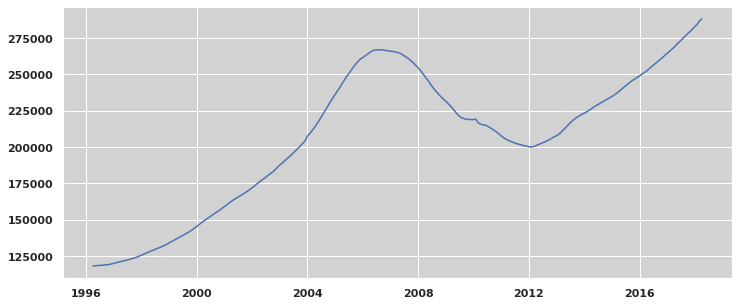

In [23]:
plt.figure(figsize = (12, 5))
plt.plot(zdf_by_zip['Nationwide']);

I'll go ahead and decompose it so I can see what the big picture looks like.

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


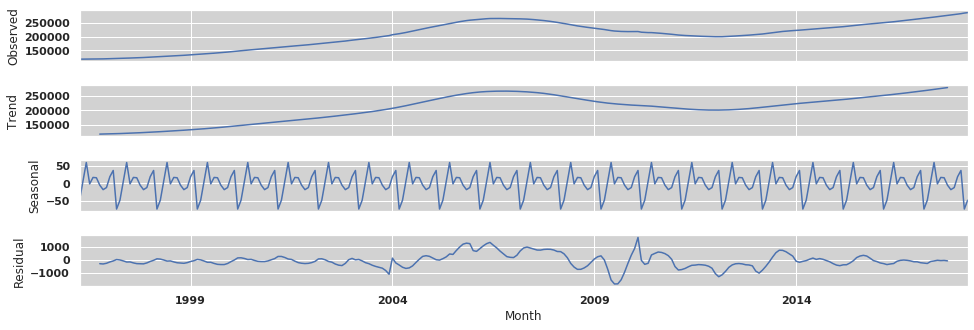

In [24]:
rcParams['figure.figsize'] = 14, 5
fig = sm.tsa.seasonal_decompose(zdf_by_zip['Nationwide']).plot();

Autocorrelation and partial autocorrelation plots to help with determing AR and MA values.

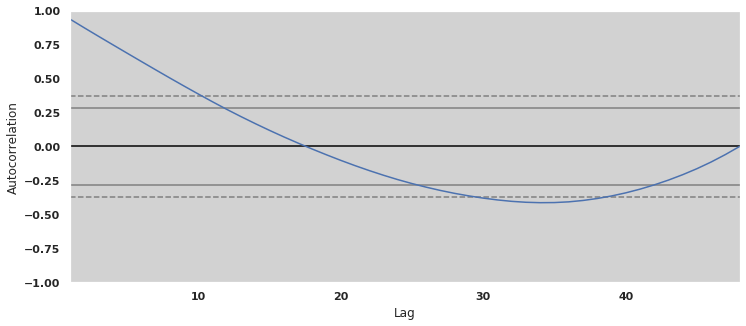

In [25]:
plt.figure(figsize=(12,5))
pd.plotting.autocorrelation_plot(zdf_by_zip['Nationwide'][-48:]);

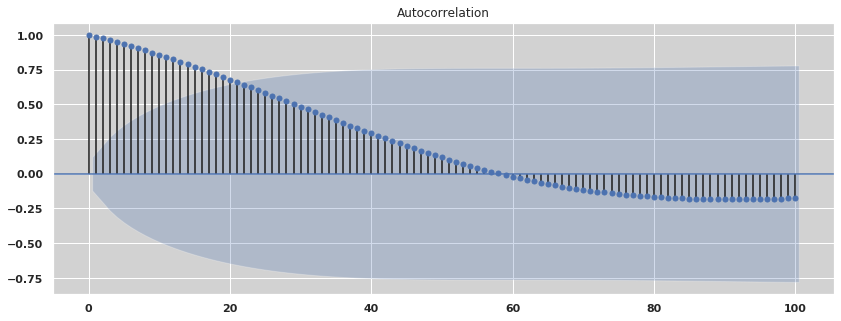

In [26]:
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 14, 5

plot_acf(zdf_by_zip['Nationwide'], lags = 100);

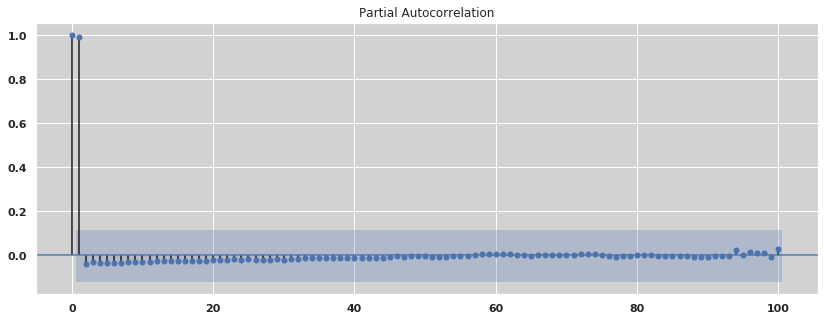

In [27]:
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 14, 5

plot_pacf(zdf_by_zip['Nationwide'], lags = 100);

I'll again use the example Portsmouth NH zipcode to see how one part of the picture might look on its own.

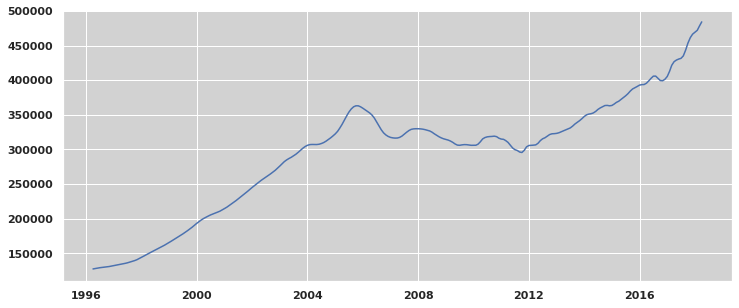

In [28]:
plt.figure(figsize = (12, 5))
plt.plot(zdf_by_zip[3801]);

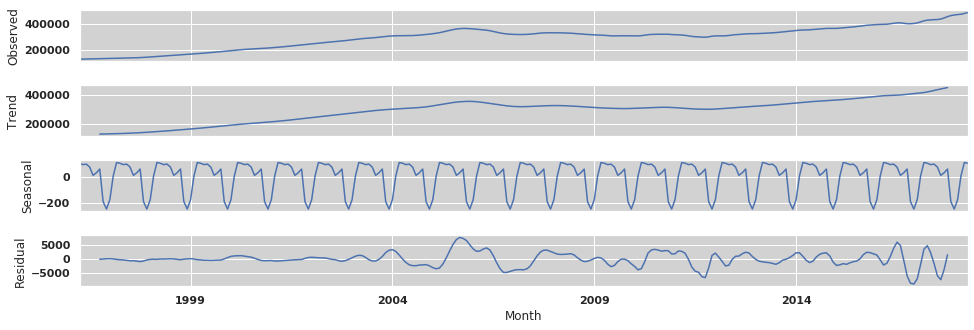

In [29]:
rcParams['figure.figsize'] = 14, 5
sm.tsa.seasonal_decompose(zdf_by_zip[3801]).plot();

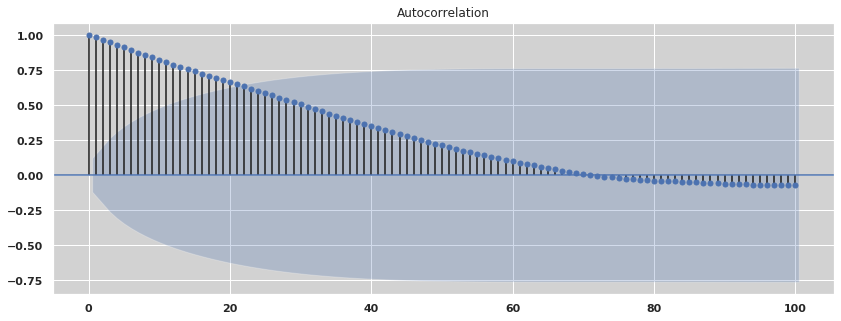

In [30]:
rcParams['figure.figsize'] = 14, 5

plot_acf(zdf_by_zip[3801], lags = 100);

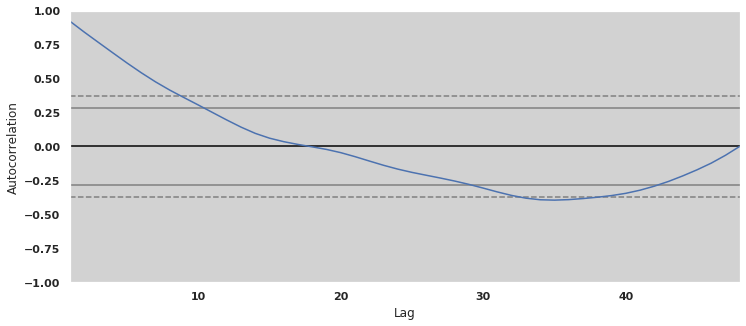

In [31]:
plt.figure(figsize=(12,5))
pd.plotting.autocorrelation_plot(zdf_by_zip[3801][-48:]);

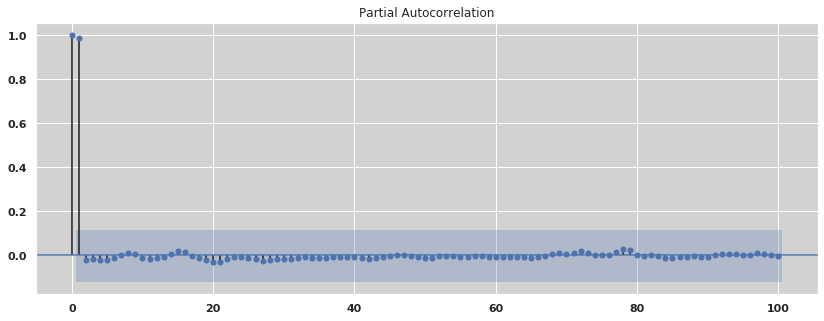

In [32]:
rcParams['figure.figsize'] = 14, 5

plot_pacf(zdf_by_zip[3801], lags = 100);

# ARIMA Modeling

Again, starting with the national average to get a high-level overview.

I'm going to begin by iterating over models to find the version with parameters that enable the lowest aic value.

## Determining Parameters

I'll try to first find the optimal pdq and PDQS values.

The majority of my time was spent determining hyperparameters. 

I found that the lowest AIC figures were not necessarily the best ones to use. For example, many of the restults prescribed a differencing (d) level of 2. However, upon comparing this order with others that had AIC scores nearlly as low, I found that the confidence intervals for the d = 2 orders were massively larger than some of the others. Higher differencing also made for a steeper slope, which I was hesitent to use in real estate since a line curving upward seems overly optimistic, and to stay on the conservative side.

In addition, since I was beginning at the national level, I needed to find a way to model all 14,000 records without necessarily determining unique parameters for each one, which would have taken weeks of computing time. In investigating individual zip codes, I found that the top order sets were very close to each other in terms of AIC and forecasted value, once differencing was taken at a value of 1 as standard. Knowing this, I set out to find the best possible 'universal key' parameters that might work for the highest number of zip codes. It might not be perfect for each zip, but it was the best way of approximating the overall set and finding a strong outcome for the top zips in the nation.

### ARIMA Version

Here, I'm generating 25 random samples with replacement to determine which order sets wind up at the top. I will ultimately take the top 10 scores from 25 different zip codes, keep only the codes they **all** have in common, and then I will run that test 25 times, then tally the results and pick the very best scoring set of parameters.

In [33]:
#Generate a list of all zips and select a sample of 25.
order_list = []

for _ in range(0, 25):
    zip_list = zdf_by_zip.columns
    random_zips = np.random.choice(zip_list, 25)
    zip_dict = dict()
    univ_list = []

    for azip in random_zips: 
        # Running the aic_search function that will populate the dictionary
        # with the top ten order combinations for each selected zip.
        # aic_search is defined above with my functions.
        univ_list, order_df, fails = aic_search(zdf_by_zip[azip], p_max = 2,
                                                d_max = 2,  
                                                q_max = 2,
                                                end = '2017-04-01')
    
    # The next piece really weird. I got a very strange error when running the above
    # code. When inputting the zip directly, it worked great. When inputting
    # from the random list, it failed. Only for a differenccing of 2. 
    # Weird, right? After much attempted debugging with 
    # changing the type etc., I found that running it twice woked fine. Go 
    # figure. I just ran the same line twice. 
    for azip in random_zips:
        univ_list, order_df, fails = aic_search(zdf_by_zip[azip], p_max = 4, 
                                                d_max = 2, 
                                                q_max = 4,
                                                end = '2017-04-01')

        # The loop updates univ_list with the combinations as they are tried.
        # We only use the ones that have 10 or more combinations and take the top 
        # ten from the ones that do.
        univ_list = [x[0] for x in univ_list]
        if len(univ_list) >= 10:
            zip_dict[azip] = univ_list[:10]

    # Initialize the list that will temporarily house the dict values as the 
    # dict is iterated.
    comb_list = []
    
    # Now I have a dict with zips as the keys and lists of 10 top order sets
    # as the values.
    start = 0
    for v in zip_dict.values():
        # If this is the first run, I'll need to move over the values from the 
        # first entry to get things started. Otherwise it has nothing to 
        # compare itself against for paring. And there is no need to compare
        # it against itself.
        if start == 0:
            comb_list = v.copy()
            start = 1
        # This is where I'm paring down the list to only those order sets
        # that the zip codes have in common in their top ten.
        for i in comb_list:
            if i in v:
                # If the value is still here in this next entry, good, move on.
                continue
            else:
                # If it's not, takie it out of the master list.
                comb_list.remove(i)
                continue
    
    # Appending the master list of all the combinations across 25 random runs 
    # of 25 zip codes each.
    order_list.append(comb_list)


In [34]:
# Making a copy since that job takes a long time to run and I don't want to 
# lose the info.
order_list2 = order_list.copy()

# Flatten so that all order sets are in one list. Sources don't matter now.
flat_list = [item for sublist in order_list2 for item in sublist]

# Make them unique.
set_list = set(flat_list)

# Setting up the final dictionary for all the order set counts.
counted_orders = dict()

# Tallying the total combinations that were in the most sets throughout the tests.
for orders in set_list:
    counted_orders[orders] = flat_list.count(orders)

counted_orders

{(3, 1, 1): 13,
 (1, 1, 3): 22,
 (2, 1, 3): 2,
 (1, 1, 2): 2,
 (2, 1, 2): 2,
 (3, 1, 2): 12}

Attemping this several times, 1,1,3 turned out to be the top choice every time. That's our winner, and we'll go with that for all future modeling.

Note that I ran grid searches for SARIMAX as well, but since I ultimately did not choose that modeling method, I have since removed those searches for the sake of tidiness. 

## Preliminary Tests and Forecasts

### SARIMAX Modeling

I just mentioned that I wound up not using the SARIMAX modeling, but I am keeping this part for posterity, to demonstrate some of the reasons why I chose not to pursue this method.

#### SARIMAX Nationwide Test

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9885      0.016     63.282      0.000       0.958       1.019
ma.L1         -0.2688      0.043     -6.253      0.000      -0.353      -0.185
ma.L2          0.0417      0.051      0.818      0.413      -0.058       0.142
ma.L3         -0.0374      0.063     -0.590      0.555      -0.162       0.087
sigma2      9.582e+04   3280.754     29.207      0.000    8.94e+04    1.02e+05
AIC:  2864.283183277808


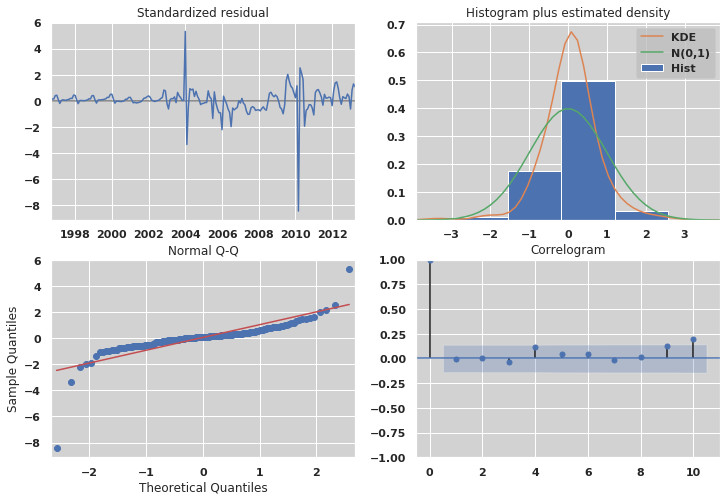

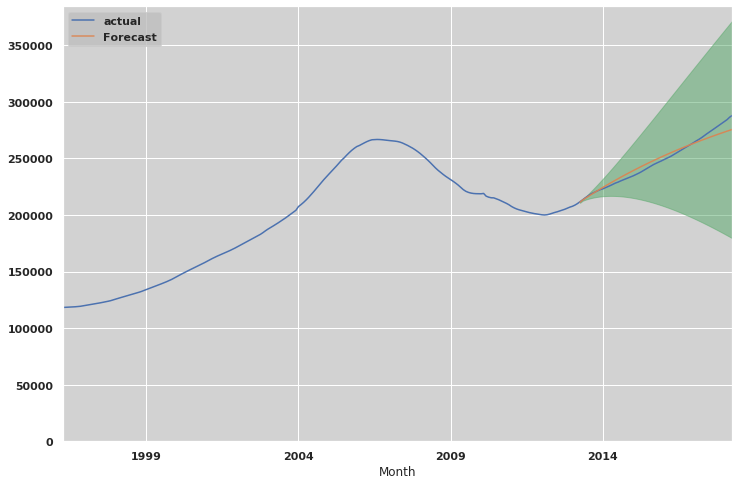

In [35]:
train_test_SARIMAX(zdf_by_zip['Nationwide'],
                   order = (1,1,3),
                   start = '2013-04-01')

#### SARIMAX Example Test

This is where I decided not to use the SARIMAX model. Some of the zip codes I looked at did not seem to work right when the seasonality was removed. They worked ok with the parameters established for seasonality, but then they broke without them. So I changed gears and went with ARIMA. 

Below is the graph for Portsmouth. There is something clearly wrong with it, as it has a strong upward trajectory up until the testing phase, then becomes a straight, flat line. With ARIMA, I didn't have this problem.

I did try this with top order sets from both SARIMAX and ARIMA, and both parameter sets had the same problem.

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8858      0.040     22.223      0.000       0.808       0.964
ma.L1          0.9376      0.060     15.543      0.000       0.819       1.056
ma.L2          0.1727      0.096      1.797      0.072      -0.016       0.361
ma.L3         -0.1219      0.048     -2.550      0.011      -0.216      -0.028
sigma2      2.901e+05   1.69e+04     17.132      0.000    2.57e+05    3.23e+05
AIC:  3104.844558781295


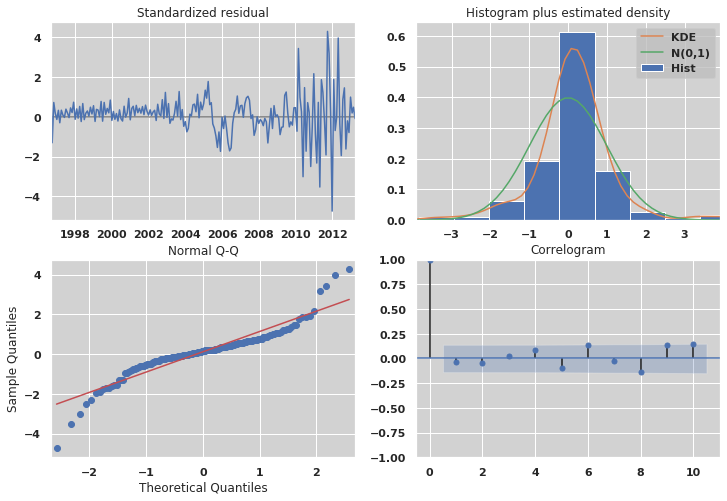

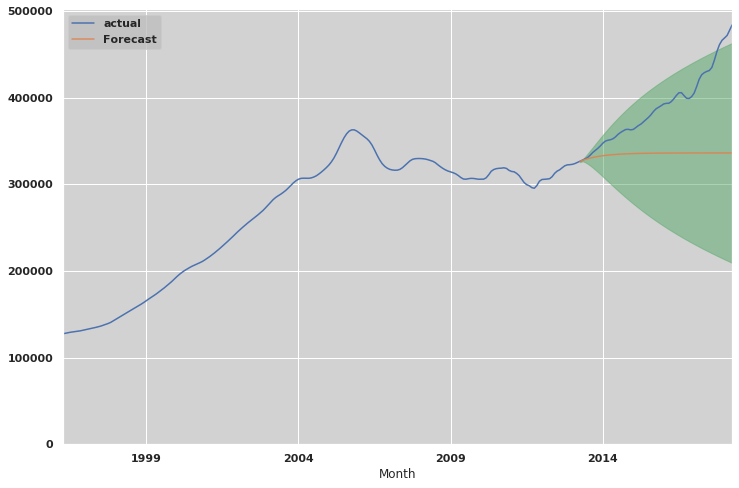

In [36]:
train_test_SARIMAX(zdf_by_zip[3801],
                   order = (1,1,3),
                   start = '2013-04-01')

#### SARIMAX Nationwide Foreccast

I'll put together a complete model including diagnostics and forecasts.

Note that I had once had a different set of numbers, including seasonal figures. I decided to get rid of the seasonal figures once I realized that although the seasonal graph shows a clear seasonal trend, the variance is so little that it isn't worth plugging in the figures.

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9518      0.007    127.622      0.000       0.937       0.966
ma.L1         -0.8947      0.010    -91.922      0.000      -0.914      -0.876
ma.L2         -0.0001      0.005     -0.019      0.985      -0.011       0.010
ma.L3          0.0095      0.005      1.948      0.051   -6.02e-05       0.019
sigma2      4.408e+05   2.65e-10   1.66e+15      0.000    4.41e+05    4.41e+05
AIC:  4356.699513358408


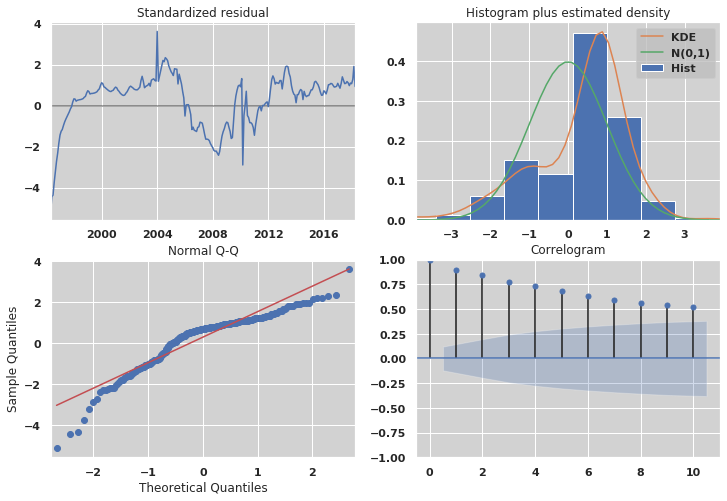

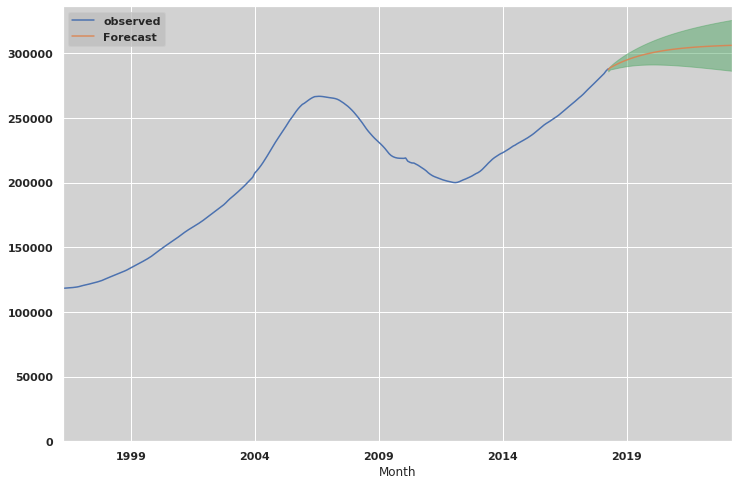

In [37]:
forecast_SARIMAX(data = zdf_by_zip['Nationwide'], 
          order = (1,1,3),
          start = '2018-04-01',
          end = '2023-04-01')

#### SARIMAX Example Forecast

Now that we have starting parameters for a nationwide model, I'll try out the model_zip function on a the same Portsmouth example from earlier.

This is going to be one of the reasons for ultimately picking ARIMA over SARIMAX for my modeling. There is something clearly wrong with the below SARIMAX model, even though order test liked this order. I specifically chose this zipcode because there's something wrong with it, to illustrate my choice of model.

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9736      0.009    102.953      0.000       0.955       0.992
ma.L1         -0.9434      0.013    -75.375      0.000      -0.968      -0.919
ma.L2          0.0443      0.008      5.826      0.000       0.029       0.059
ma.L3         -0.0484      0.007     -7.271      0.000      -0.061      -0.035
sigma2      4.535e+06    1.7e-10   2.66e+16      0.000    4.53e+06    4.53e+06
AIC:  4824.407441928715


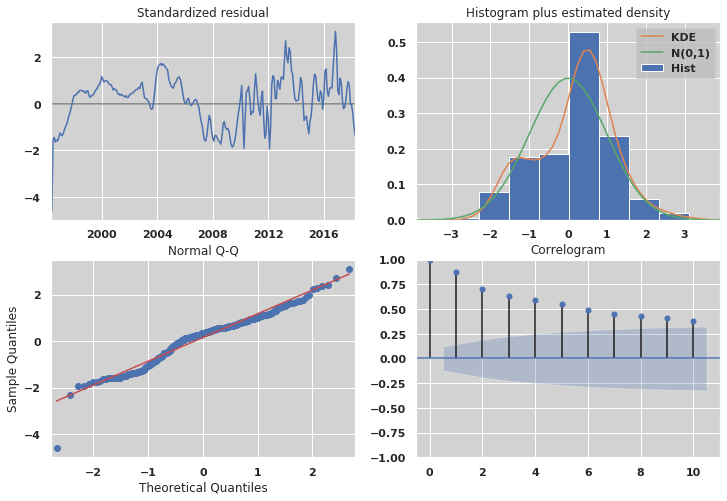

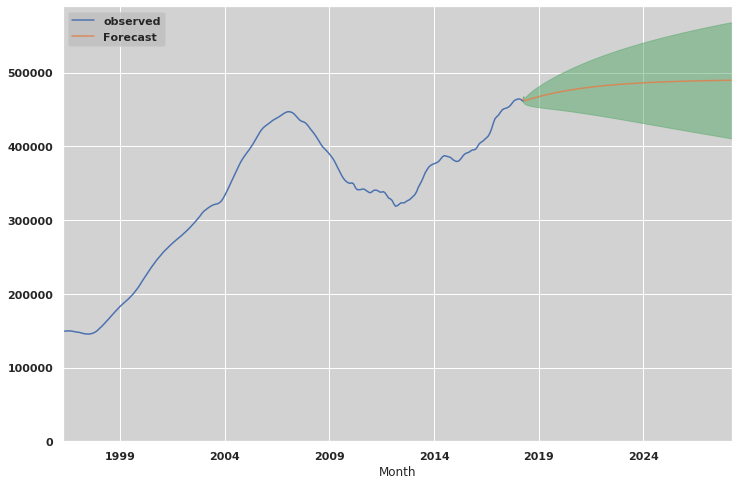

In [38]:
forecast_SARIMAX(zdf_by_zip[60625], 
          order = (1,1,3),
          start = '2018-04-01',
          end = '2028-04-01')

### ARIMA Modeling

#### ARIMA Nationwide Test

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


                             ARIMA Model Results                              
Dep. Variable:           D.Nationwide   No. Observations:                  204
Model:                 ARIMA(1, 1, 3)   Log Likelihood               -1454.808
Method:                       css-mle   S.D. of innovations            300.583
Date:                Sun, 19 Jan 2020   AIC                           2921.616
Time:                        18:31:31   BIC                           2941.524
Sample:                    05-01-1996   HQIC                          2929.669
                         - 04-01-2013                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                576.1130    663.252      0.869      0.386    -723.837    1876.063
ar.L1.D.Nationwide     0.9807      0.012     79.712      0.000       0.957       1.005
ma.L1.D.Nationwide  

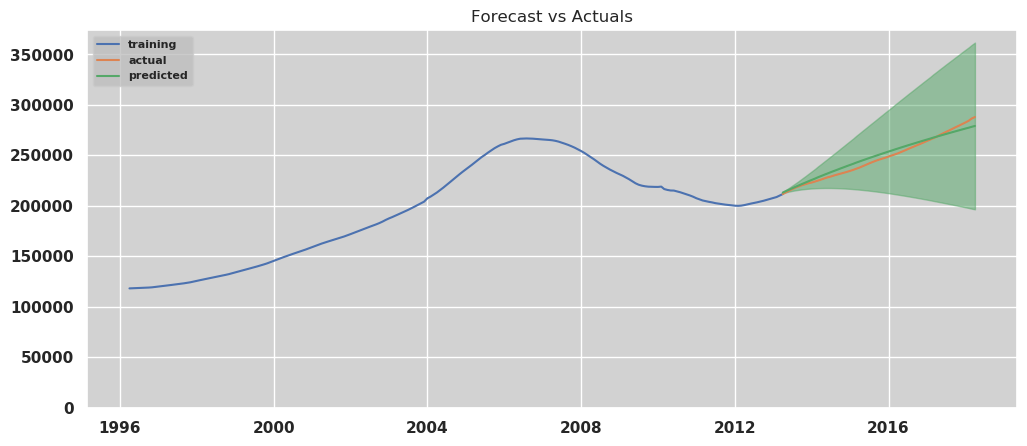

In [39]:
train_test_ARIMA(zdf_by_zip['Nationwide'], (1,1,3), start = '2013-04-01')

#### ARIMA Example Test

                             ARIMA Model Results                              
Dep. Variable:                 D.3801   No. Observations:                  204
Model:                 ARIMA(1, 1, 3)   Log Likelihood               -1570.037
Method:                       css-mle   S.D. of innovations            526.625
Date:                Sun, 19 Jan 2020   AIC                           3152.073
Time:                        21:44:52   BIC                           3171.982
Sample:                    05-01-1996   HQIC                          3160.127
                         - 04-01-2013                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          976.4706    553.550      1.764      0.079    -108.467    2061.408
ar.L1.D.3801     0.8853      0.040     22.181      0.000       0.807       0.963
ma.L1.D.3801     0.9973      0.076     13.14

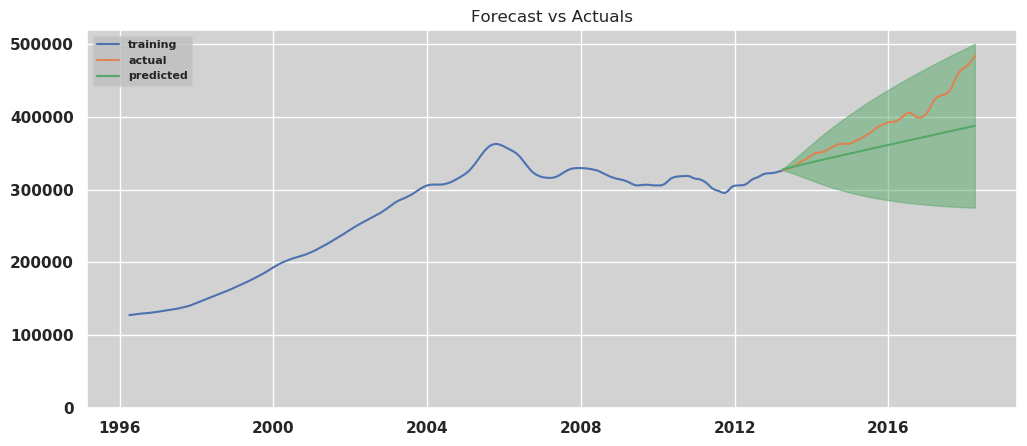

In [44]:
train_test_ARIMA(zdf_by_zip[3801], (1,1,3), start = '2013-04-01')

#### ARIMA Nationwide Forecast

In contrast to the 3801 example further up, the graph turned out differently here using an ARIMA model. For each model, I used the top order result *for that model*, so they should both be getting optimum treatment. I also tried using the same number for both, with results that were not much different. Not only did the line make more sense, but the confidence intervals are much smaller as well.

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


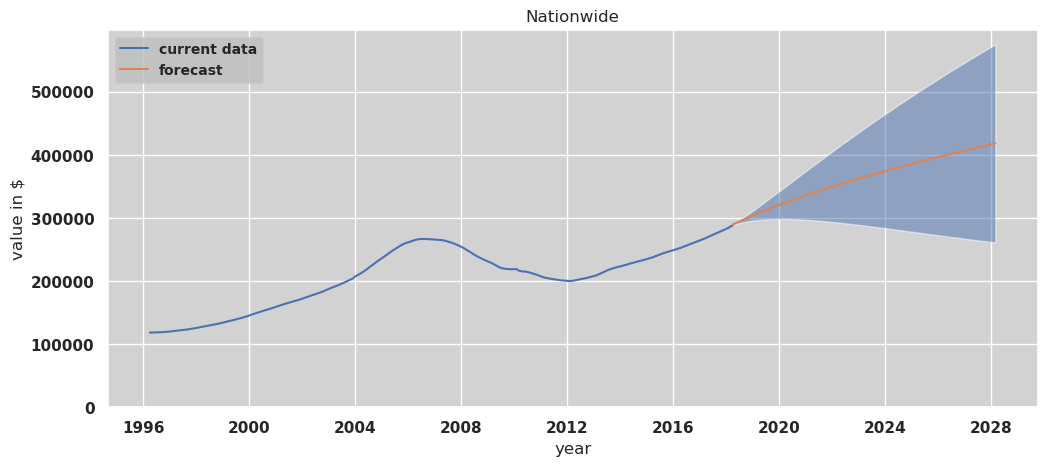

In [45]:
forecast_ARIMA(zdf_by_zip['Nationwide'], (1,1,3), forecast_length = 120)

#### ARIMA Example Forecast

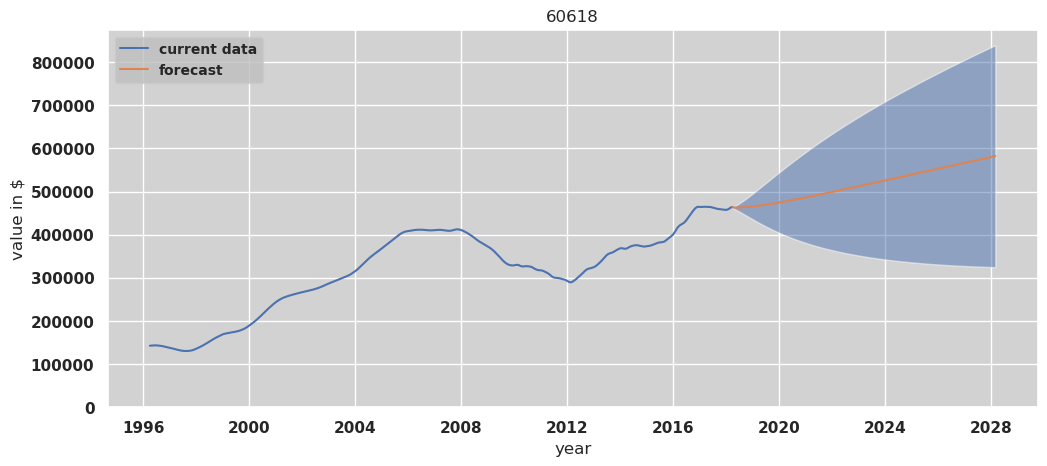

In [46]:
forecast_ARIMA(zdf_by_zip[60618], (1,1,3), forecast_length = 120)

## Modeling All Zipcodes

### Creating Supplementary DataFrame

I first need to set up the beginning of what will be the master dataframe, including all of the zip info (city etc.)

In [47]:
# Creating a basis for the columns I will want to add to the new master 
# dataframe as it is generated.
zip_info = pd.DataFrame(zdf[['RegionName', 'City', 'State', 'Metro', 
                             'CountyName', 'SizeRank']])

In [48]:
zip_info = zip_info.sort_values('RegionName')

In [49]:
zip_info.head()

,RegionName,City,State,Metro,CountyName,SizeRank
5850,1001,Agawam,MA,Springfield,Hampden,5851
4199,1002,Amherst,MA,Springfield,Hampshire,4200
11213,1005,Barre,MA,Worcester,Worcester,11214
6850,1007,Belchertown,MA,Springfield,Hampshire,6851
14547,1008,Blandford,MA,Springfield,Hampden,14548


In [50]:
zip_info.set_index(['RegionName'], inplace = True)

### Building the Model

This is the big job. I'm going to use the ARIMA modling to create a master projection DataFrame of 1-10 year projections for every zipcode in the source. Function is defined under Functions above.

national_models is defined above with the rest of my functions.

In [73]:
all_zip_models = national_models(source=zdf_by_zip, info=zip_info, 
                                 params=(1,1,3))

This took like 15 hours to run. I don't want to lose it.

In [74]:
all_zip_models.to_csv('all_zip_models_113.csv')

Below is for when I'm running off a csv, so I don't have to re-make that dataframe every time I re-run the notebook.

In [75]:
# all_zip_models = pd.read_csv('all_zip_models_113.csv')

In [76]:
all_zip_models.head()

,Zip,City,State,Metro,CountyName,SizeRank,2018-04-01,1_Year,1_Gain,2_Year,2_Gain,3_Year,3_Gain,4_Year,4_Gain,5_Year,5_Gain,6_Year,6_Gain,7_Year,7_Gain,8_Year,8_Gain,9_Year,9_Gain,10_Year,10_Gain
0,1001,Agawam,MA,Springfield,Hampden,5851,223600.0,228007.34,0.02,232698.84,0.04,237330.68,0.06,241936.88,0.08,246532.07,0.10,251122.53,0.12,255710.95,0.14,260298.50,0.16,264885.68,0.18,269472.69,0.21
1,1002,Amherst,MA,Springfield,Hampshire,4200,353300.0,371533.37,0.05,383994.76,0.09,394106.87,0.12,403327.09,0.14,412208.71,0.17,420961.77,0.19,429666.04,0.22,438351.77,0.24,447030.47,0.27,455706.50,0.29
2,1005,Barre,MA,Worcester,Worcester,11214,220700.0,233987.20,0.06,244116.51,0.11,252374.41,0.14,259605.39,0.18,266272.83,0.21,272631.05,0.24,278819.57,0.26,284914.98,0.29,290959.29,0.32,296975.56,0.35
3,1007,Belchertown,MA,Springfield,Hampshire,6851,270600.0,275322.74,0.02,280590.95,0.04,285931.71,0.06,291313.87,0.08,296719.63,0.10,302138.86,0.12,307565.76,0.14,312997.04,0.16,318430.83,0.18,323866.03,0.20
4,1008,Blandford,MA,Springfield,Hampden,14548,214200.0,224827.76,0.05,230960.68,0.08,235983.13,0.10,240716.62,0.12,245374.91,0.15,250013.64,0.17,254647.27,0.19,259279.58,0.21,263911.55,0.23,268543.43,0.25


Getting rid of null values that will mess up my DataFrame.

In [77]:
# Create a list of zipcodes with null values.
null_zips = []

for column in zdf_by_zip.columns:
    if zdf_by_zip[column].isnull().sum() > 0:
        null_zips.append(column)
        

In [78]:
# Remove everything from that list.
for zip in null_zips:
    try:
        all_zip_models.drop(all_zip_models[all_zip_models['Zip'] == zip].index,
                           inplace = True)
    except:
        continue

Check to see how many records have been cut from the original, after nulls were removed and some models no doubt failed. 

In [79]:
all_zip_models.shape

(13594, 27)

Resetting the index for the sake of the loaded file.

In [80]:
# all_zip_models = all_zip_models.drop(['Unnamed: 0'], axis = 1)

In [81]:
all_zip_models.head()

,Zip,City,State,Metro,CountyName,SizeRank,2018-04-01,1_Year,1_Gain,2_Year,2_Gain,3_Year,3_Gain,4_Year,4_Gain,5_Year,5_Gain,6_Year,6_Gain,7_Year,7_Gain,8_Year,8_Gain,9_Year,9_Gain,10_Year,10_Gain
0,1001,Agawam,MA,Springfield,Hampden,5851,223600.0,228007.34,0.02,232698.84,0.04,237330.68,0.06,241936.88,0.08,246532.07,0.10,251122.53,0.12,255710.95,0.14,260298.50,0.16,264885.68,0.18,269472.69,0.21
1,1002,Amherst,MA,Springfield,Hampshire,4200,353300.0,371533.37,0.05,383994.76,0.09,394106.87,0.12,403327.09,0.14,412208.71,0.17,420961.77,0.19,429666.04,0.22,438351.77,0.24,447030.47,0.27,455706.50,0.29
2,1005,Barre,MA,Worcester,Worcester,11214,220700.0,233987.20,0.06,244116.51,0.11,252374.41,0.14,259605.39,0.18,266272.83,0.21,272631.05,0.24,278819.57,0.26,284914.98,0.29,290959.29,0.32,296975.56,0.35
3,1007,Belchertown,MA,Springfield,Hampshire,6851,270600.0,275322.74,0.02,280590.95,0.04,285931.71,0.06,291313.87,0.08,296719.63,0.10,302138.86,0.12,307565.76,0.14,312997.04,0.16,318430.83,0.18,323866.03,0.20
4,1008,Blandford,MA,Springfield,Hampden,14548,214200.0,224827.76,0.05,230960.68,0.08,235983.13,0.10,240716.62,0.12,245374.91,0.15,250013.64,0.17,254647.27,0.19,259279.58,0.21,263911.55,0.23,268543.43,0.25


Since that DataFrame is such a bear to create, I'll copy it before doing any damage.

In [82]:
all_zip_ranked = all_zip_models.sort_values('10_Gain', ascending = False)

Adding in a column to display each zip's overall rank.

In [83]:
all_zip_ranked['Rank'] = [i + 1 for i in range(0, len(all_zip_ranked))]

In [84]:
all_zip_ranked.head(20)

,Zip,City,State,Metro,CountyName,SizeRank,2018-04-01,1_Year,1_Gain,2_Year,2_Gain,3_Year,3_Gain,4_Year,4_Gain,5_Year,5_Gain,6_Year,6_Gain,7_Year,7_Gain,8_Year,8_Gain,9_Year,9_Gain,10_Year,10_Gain,Rank
4166,28208,Charlotte,NC,Charlotte,Mecklenburg,1822,113400.0,134125.73,0.18,154528.76,0.36,173794.81,0.53,192024.12,0.69,209308.07,0.85,225729.99,0.99,241365.89,1.13,256285.04,1.26,270550.63,1.39,284220.27,1.51,1
10292,76114,Fort Worth,TX,Dallas-Fort Worth,Tarrant,4577,137000.0,166351.57,0.21,193213.42,0.41,217480.57,0.59,239517.57,0.75,259637.77,0.90,278110.47,1.03,295167.17,1.15,311006.80,1.27,325800.37,1.38,339694.85,1.48,2
5733,37020,Bell Buckle,TN,Shelbyville,Bedford,10884,202800.0,238455.82,0.18,271884.42,0.34,302943.53,0.49,331915.85,0.64,359050.36,0.77,384566.33,0.90,408656.85,1.02,431492.00,1.13,453221.56,1.23,473977.44,1.34,3
265,2127,Boston,MA,Boston,Suffolk,1512,807900.0,898584.22,0.11,995029.86,0.23,1090939.51,0.35,1186337.76,0.47,1281248.08,0.59,1375692.84,0.70,1469693.40,0.82,1563270.13,0.93,1656442.48,1.05,1749229.00,1.17,4
6178,39629,Bogue Chitto,MS,Brookhaven,Lincoln,9897,132500.0,178103.63,0.34,205245.39,0.55,223614.69,0.69,236942.60,0.79,247373.32,0.87,256139.07,0.93,263948.00,0.99,271207.06,1.05,278150.12,1.10,284911.57,1.15,5
5797,37160,Shelbyville,TN,Shelbyville,Bedford,2555,136100.0,157381.08,0.16,176967.67,0.30,194751.50,0.43,211002.97,0.55,225951.92,0.66,239793.72,0.76,252694.42,0.86,264795.18,0.95,276215.97,1.03,287058.80,1.11,6
10111,75217,Dallas,TX,Dallas-Fort Worth,Dallas,226,111300.0,126725.16,0.14,141954.39,0.28,156150.15,0.40,169428.49,0.52,181892.39,0.63,193633.31,0.74,204732.42,0.84,215261.77,0.93,225285.33,1.02,234859.90,1.11,7
10693,78210,San Antonio,TX,San Antonio,Bexar,2363,119400.0,140988.62,0.18,159851.70,0.34,176236.64,0.48,190610.87,0.60,203353.68,0.70,214772.81,0.80,225117.94,0.89,234591.66,0.96,243358.35,1.04,251551.37,1.11,8
5523,34691,Holiday,FL,Tampa,Pasco,4020,104800.0,131511.18,0.25,151204.03,0.44,166109.74,0.59,177781.59,0.70,187268.86,0.79,195280.39,0.86,202295.02,0.93,208636.19,0.99,214522.44,1.05,220101.37,1.10,9
1294,8611,Trenton,NJ,Trenton,Mercer,5279,45900.0,60243.86,0.31,70117.80,0.53,77039.38,0.68,82008.26,0.79,85685.59,0.87,88508.69,0.93,90766.80,0.98,92651.20,1.02,94288.45,1.05,95762.21,1.09,10


# Assessment

My goal here is going to be to drill down to the state, county, and city levels to find the top area before determining the top zip codes, in order to identify an area that is more secure in the surrounding areas.

In [85]:
state_group = group_areas(all_zip_ranked, 'State', 10)

In [86]:
state_group["PercentGain"] = state_group['10_Gain'] * 100
state_group['PercentGain'] = state_group['PercentGain'].astype(int)

In [87]:
state_group.head()

,10_Gain,Rank,PercentGain
State,,,
CO,0.376599,1,37
WA,0.376518,2,37
FL,0.366317,3,36
NV,0.364545,4,36
SD,0.348000,5,34


In [88]:
state_group.index[0]

'CO'

Below code was used to generate a US map for the presenation, through plotly's Web interface.

In [89]:
# import plotly.plotly as py
# import chart_studio

# chart_studio.tools.set_credentials_file(username='terryollila', api_key='JG9BIy9Sn131zwKgTQGW')

# scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
#             [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

# # df['text'] = df['state'] + '<br>' +\
# #     'Beef '+df['beef']+' Dairy '+df['dairy']+'<br>'+\
# #     'Fruits '+df['total fruits']+' Veggies ' + df['total veggies']+'<br>'+\
# #     'Wheat '+df['wheat']+' Corn '+df['corn']

# data = [ dict(
#         type='choropleth',
#         colorscale = scl,
#         autocolorscale = False,
#         locations = state_group.index,
#         z = state_group['PercentGain'],
#         locationmode = 'USA-states',
#         text = state_group.index,
#         marker = dict(
#             line = dict (
#                 color = 'rgb(255,255,255)',
#                 width = 2
#             )
#         ),
#         colorbar = dict(
#             title = "% Gain"
#         )
#     ) ]

# layout = dict(
#         title = 'Forecasted Real Estate Growth by State\n2018 - 2028',
#         geo = dict(
#             scope='usa',
#             projection=dict( type='albers usa' ),
#             showlakes = True,
#             lakecolor = 'rgb(255, 255, 255)',
#         ),
#     )

# fig = dict( data=data, layout=layout )

# url = py.plot( fig, filename='d3-cloropleth-map' )

## Find the Top Cities in Each County

This is going to be the final result. I'm going to take the top zip code, and from there I'll take the top county, then from inside that county I will take the top city, and within the top city, I will take 5 top zip codes as the final recommendation.

The below function does all the heavy of the drill-down from state to zip level. It's defined with my other functions above.

In [90]:
top_zips = drill_for_zips('CO', data=all_zip_ranked, num_results = 10, years_ahead = 10)

In [91]:
top_zips

,Zip,City,State,Metro,CountyName,SizeRank,2018-04-01,1_Year,1_Gain,2_Year,2_Gain,3_Year,3_Gain,4_Year,4_Gain,5_Year,5_Gain,6_Year,6_Gain,7_Year,7_Gain,8_Year,8_Gain,9_Year,9_Gain,10_Year,10_Gain,Rank
11012,80204,Denver,CO,Denver,Denver,2156,371600.0,417634.06,0.12,460441.08,0.24,499683.23,0.34,535891.86,0.44,569519.10,0.53,600949.71,0.62,630511.10,0.70,658481.88,0.77,685099.13,0.84,710564.58,0.91,32
11011,80203,Denver,CO,Denver,Denver,1941,571500.0,640146.30,0.12,699335.96,0.22,750624.50,0.31,795887.03,0.39,836553.68,0.46,873715.16,0.53,908203.32,0.59,940652.60,0.65,971546.88,0.70,1001255.20,0.75,102
11023,80219,Denver,CO,Denver,Denver,611,315700.0,348074.83,0.10,376272.10,0.19,400569.75,0.27,421963.48,0.34,441194.74,0.40,458815.70,0.45,475237.50,0.51,490766.34,0.55,505630.22,0.60,519998.91,0.65,190
11027,80223,Denver,CO,Denver,Denver,5869,331000.0,364571.67,0.10,393687.79,0.19,418903.88,0.27,441196.73,0.33,461298.50,0.39,479757.98,0.45,496986.49,0.50,513292.35,0.55,528906.65,0.60,544002.58,0.64,198
11028,80224,Denver,CO,Denver,Denver,5211,500700.0,542332.61,0.08,581473.44,0.16,617373.03,0.23,650558.40,0.30,681470.90,0.36,710480.09,0.42,737895.45,0.47,763976.15,0.53,788939.19,0.58,812966.32,0.62,253
11039,80236,Denver,CO,Denver,Denver,6891,382500.0,423570.84,0.11,457365.24,0.20,485565.91,0.27,509788.20,0.33,531180.99,0.39,550561.37,0.44,568510.48,0.49,585441.64,0.53,601648.81,0.57,617341.07,0.61,267
11022,80218,Denver,CO,Denver,Denver,3055,773400.0,857125.55,0.11,922077.80,0.19,975320.98,0.26,1020974.67,0.32,1061709.05,0.37,1099254.87,0.42,1134733.96,0.47,1168873.45,0.51,1202144.64,0.55,1234853.03,0.60,292
11019,80212,Denver,CO,Denver,Denver,4845,510000.0,557325.90,0.09,598413.86,0.17,633836.33,0.24,665228.48,0.30,693753.56,0.36,720239.05,0.41,745273.62,0.46,769276.04,0.51,792544.20,0.55,815290.03,0.60,293
11018,80211,Denver,CO,Denver,Denver,1388,546600.0,594501.05,0.09,637074.86,0.17,674311.10,0.23,707684.86,0.29,738263.55,0.35,766819.63,0.40,793912.05,0.45,819945.30,0.50,845212.10,0.55,869924.26,0.59,320
11042,80239,Denver,CO,Denver,Denver,3344,298800.0,324306.36,0.09,346878.56,0.16,366328.38,0.23,383529.94,0.28,399112.64,0.34,413529.69,0.38,427107.42,0.43,440080.80,0.47,452619.03,0.51,464843.91,0.56,392


# Interpreting Results

Analyzing an entire nation of zipcodes is not going to be as precise as measuring a handful of zip codes at once. However, with a little work we can create some modeling that can, at the very least, drill into the zip codes that are, if not at the very top, at least near the top in terms of percent growth over the coming years.

The thing I did *not* do was to simply take the five top zip codes in the country. There is too much possibility for error with that tactic, and the areas picked would lack the strength of the surrounding areas to mitigate risk. Also, those zipcodes could be isolted flukes.

Instead, in trying to mitigate risk and hone in on the best overall area, and then the best zipcodes within that area, I began at the state level and picked the state with the top average percent gain over ten years. I then drilled down to the county level and picked the top county. From there, I went to the top city, and picked zipcodes from there. This process should insulate the picks from risk as it accounts for strength not only in its own area, but in the surrounding area as well. The strongest zips from the strongest cities from the strongest counties from the strongest state.

In the end, Colorado was the top state, with Denver being the top country, Denver also being the top state, and the five zip codes listed below as the top 5 recommended zip codes for real estate investment nationwide. Since all five were in close proximity to each other, I feel that this reflects great strength in the area and the chances of any one of these zipcodes having come from any sort of anomaly is extremely low.

Oh yes, and for all you sports fans, the top zip encompasses both Mile High Stadium and the Pepsi center.

The top zip code of all was 80204:

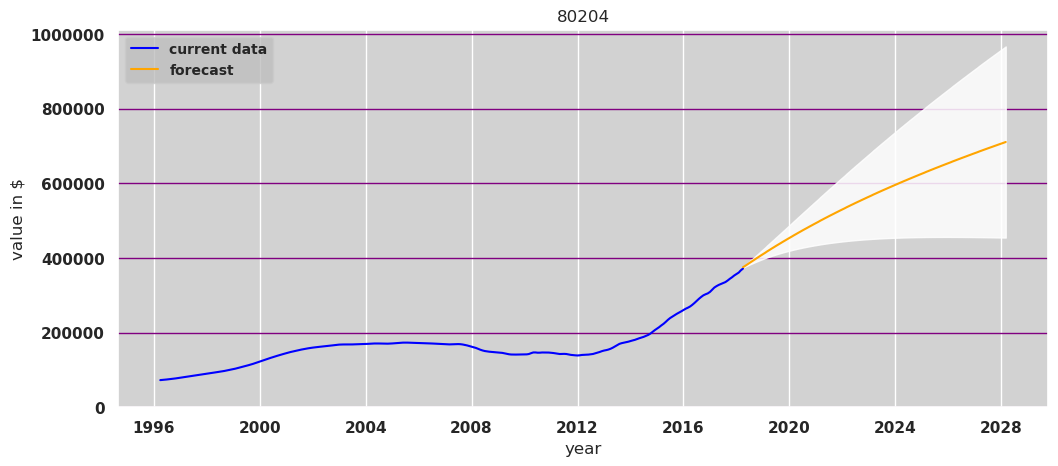

In [92]:
forecast_ARIMA(zdf_by_zip[80204], order=(1,1,3), forecast_length=120, 
               diagnostics=False, denver=True)

Denver has been experiencing explosive growth in recent years as a magnet for technology companies new and old to gather. 

You don't necessarily need to buy right close to the stadiums, though, and fight all that traffic. These other zip codes are also very strong in their own right, and none of them is far from downtown.

80203, 80219, 80223, 80224.

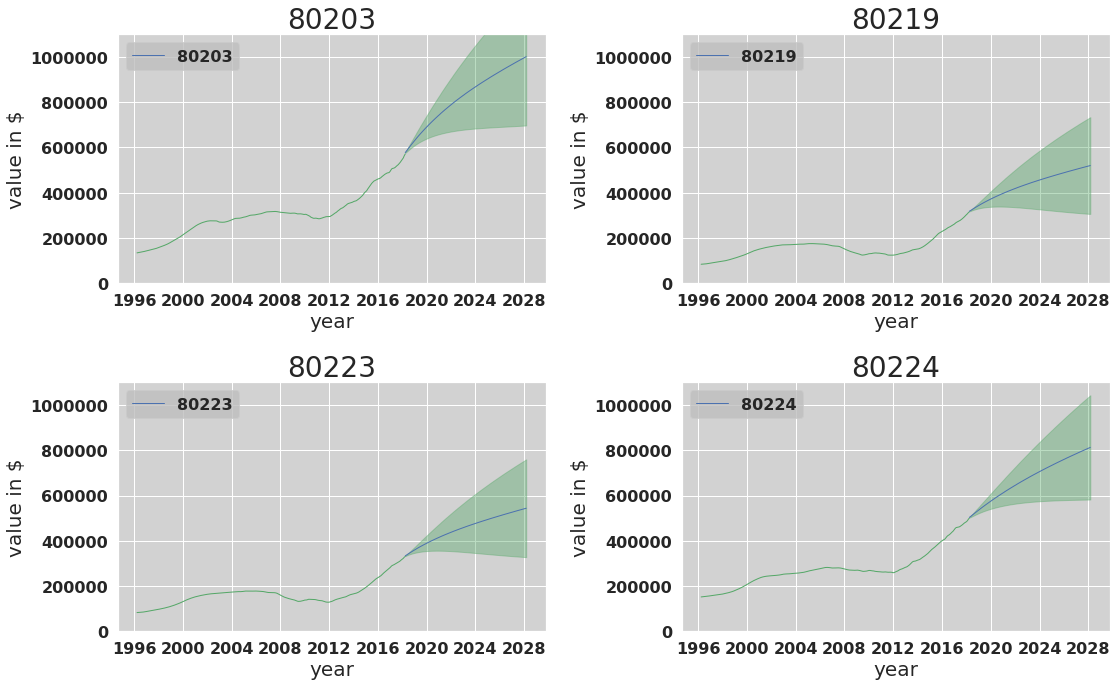

In [93]:
# Creating subplots for each of the other 4 Denver zip codes in top 5.

fig, axes = plt.subplots(2,2, figsize=(16,10))

forecast_ARIMA_sub(zdf_by_zip[80203], ax=axes[0,0], order=(1,1,3), 
                   forecast_length=120, diagnostics=False)
forecast_ARIMA_sub(zdf_by_zip[80219], ax=axes[0,1], order=(1,1,3), 
                   forecast_length=120, diagnostics=False)
forecast_ARIMA_sub(zdf_by_zip[80223], ax=axes[1,0], order=(1,1,3), 
                   forecast_length=120, diagnostics=False)
forecast_ARIMA_sub(zdf_by_zip[80224], ax=axes[1,1], order=(1,1,3), 
                   forecast_length=120, diagnostics=False)

plt.tight_layout()
plt.show();

Plotting them all together for comparison.

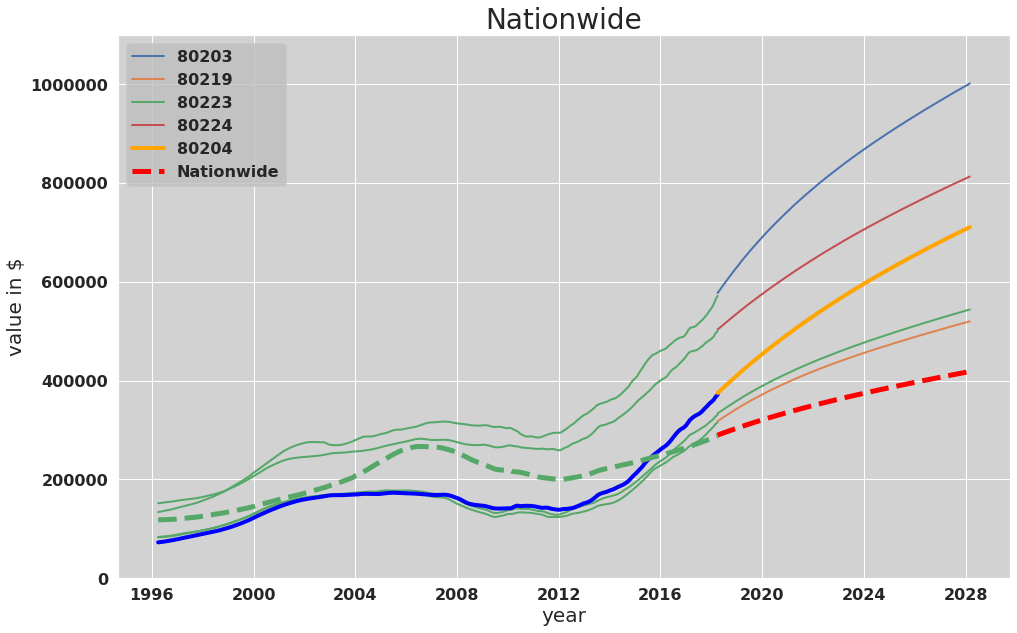

In [94]:
fig, axes = plt.subplots(1,1,figsize=(16,10))

ax = axes

order = (1,1,3)

forecast_ARIMA_sub(zdf_by_zip[80203], ax=ax, order=(order), 
                   forecast_length=120, diagnostics=False, intervals=False,
                   lw=2)
forecast_ARIMA_sub(zdf_by_zip[80219], ax=ax, order=(order), 
                   forecast_length=120, diagnostics=False, intervals=False,
                   lw=2)
forecast_ARIMA_sub(zdf_by_zip[80223], ax=ax, order=(order), 
                   forecast_length=120, diagnostics=False, intervals=False,
                   lw=2)
forecast_ARIMA_sub(zdf_by_zip[80224], ax=ax, order=(order), 
                   forecast_length=120, diagnostics=False, intervals=False,
                   lw=2)
forecast_ARIMA_sub(zdf_by_zip[80204], ax=ax, order=(order), 
                   forecast_length=120, diagnostics=False, 
                   intervals=False, denver = True, lw = 4)
forecast_ARIMA_sub(zdf_by_zip['Nationwide'], ax=ax, order=(order), 
                   forecast_length=120, diagnostics=False, intervals=False,
                   lw=5, ls='--', color = 'red')

plt.show();

Getting 10 year forecast figure for Nationwide model since that information doesn't yet exist outside of a function.

In [95]:
    # Same model used for everything else.
    model = statsmodels.tsa.arima_model.ARIMA(zdf_by_zip['Nationwide'], 
                                              order=(1,1,3)) 
    fitted = model.fit()  
    fc, se, conf = fitted.forecast(120, alpha=0.05)
    # Calculating the % increase over 10 years and confidence intervals.
    nat_roi = round((fc[-1] - fc[0]) / fc[0],2)
    nat_conf = (conf[-1,1] - conf[-1,0]) / conf[-1,1]

Bar graphs to demonstrate return on investment over the next ten years.

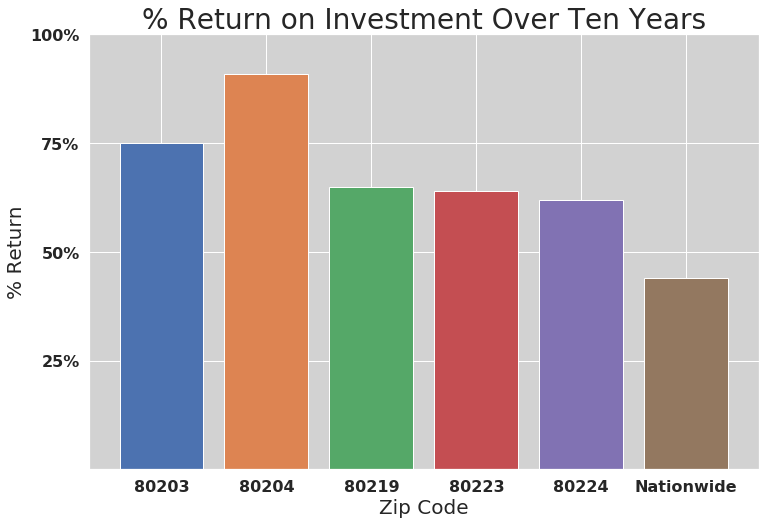

In [96]:
top_list = list(top_zips['Zip'][0:5])
# top_list = [80204, 80203, 80219, 80223, 80224]

# Since I made 80204 oroange before, it will be too confusing to make it 
# orange now, and I don't want to go into making a specific assignment again.
temp = top_list[0]
top_list[0] = top_list[1]
top_list[1] = temp

plt.figure(figsize = (12,8))
plt.title('% Return on Investment Over Ten Years', fontsize = 28)
for azip in top_list:
    gain = top_zips[top_zips['Zip'] == azip]['10_Gain']
    plt.bar(str(azip), gain*100)
plt.bar('Nationwide', nat_roi*100)
plt.ylabel('% Return', fontsize = 20)
plt.xlabel('Zip Code', fontsize = 20)
plt.yticks(ticks = [25, 50, 75, 100], labels = ('25%', '50%', '75%', '100%'))
plt.tick_params(axis="x", labelsize=16)
plt.tick_params(axis="y", labelsize=16)
plt.show()

Similarly represnting the dollar amonunt of gain over ten years given a purchase price of the current average. 80203 takes top honors there, but you'll need a fatter pocket book to make that money.

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


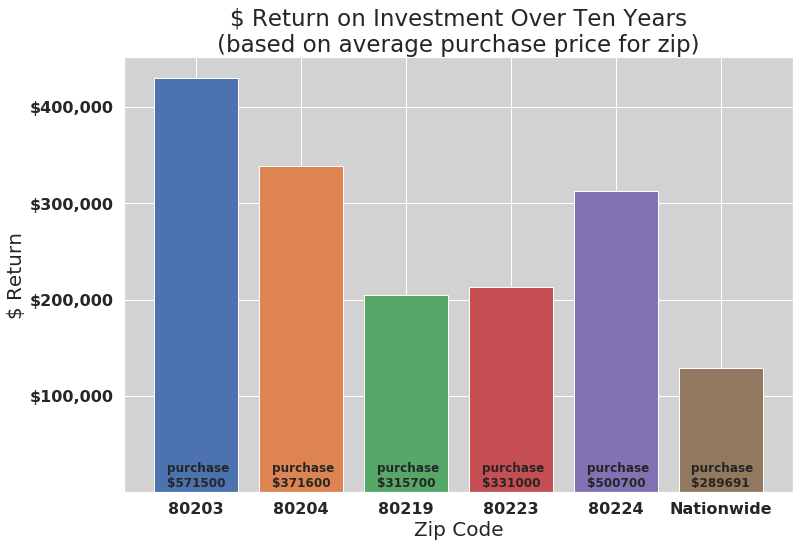

In [97]:
# Since I made 80204 oroange before, it will be too confusing to make it 
# orange now, and I don't want to go into making a specific assignment again.

# Define the national increase
nat_net = fc[-1] - fc[0]

# Create the graph
fig, ax = plt.subplots(figsize = (12,8))
plt.title('$ Return on Investment Over Ten Years\n(based on average purchase price for zip)',
          fontsize = 23)
i=0
for azip in top_list:
    gain_start = top_zips[top_zips['Zip'] == azip]['2018-04-01']
    gain_end = top_zips[top_zips['Zip'] == azip]['10_Year']
    dol_gain = top_zips[top_zips['Zip'] == azip]['10_Year'] - top_zips[
        top_zips['Zip'] == azip]['2018-04-01']
    ax.bar(str(azip), dol_gain)
    plt.annotate(str(f'purchase\n${int(gain_start)}'), (i-.28,6000), fontsize = 12)
    i += 1

plt.bar('Nationwide', nat_net)
plt.yticks(ticks = [100000, 200000, 300000, 400000], labels = ('$100,000',
                                                               '$200,000',
                                                               '$300,000',
                                                               '$400,000'))
plt.ylim(0)
plt.ylabel('$ Return', fontsize = 20)
plt.xlabel('Zip Code', fontsize = 20)
plt.annotate(f'purchase\n${int(fc[0])}', (5-.28,6000), fontsize = 12)
plt.tick_params(axis="x", labelsize=16)
plt.tick_params(axis="y", labelsize=16)
plt.show()